## Day 35 Lecture 1 Assignment

In this assignment, we will learn about gradient boosting. We will use a dataset describing survival rates after breast cancer surgery loaded below and analyze the model generated for this dataset.

In [1]:
%matplotlib inline

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [2]:
# Attributes:
# Age of patient at time of operation (numerical)
# Patient's year of operation (year - 1900, numerical)
# Number of positive axillary nodes detected (numerical)
# Survival status (class attribute)
#  -- 1 = the patient survived 5 years or longer
#  -- 2 = the patient died within 5 year

cols = ['age', 'op_year', 'nodes', 'survival']
cancer = pd.read_csv('https://tf-assets-prod.s3.amazonaws.com/tf-curric/data-science/haberman.data', names=cols)

In [3]:
cancer.head()

,age,op_year,nodes,survival
0,30,64,1,1
1,30,62,3,1
2,30,65,0,1
3,31,59,2,1
4,31,65,4,1


Check for missing data and remove all rows containing missing data

In [4]:
cancer.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 306 entries, 0 to 305
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype
---  ------    --------------  -----
 0   age       306 non-null    int64
 1   op_year   306 non-null    int64
 2   nodes     306 non-null    int64
 3   survival  306 non-null    int64
dtypes: int64(4)
memory usage: 9.7 KB


In [5]:
# answer below:
cancer.isnull().sum()/cancer.isnull().count()

age         0.0
op_year     0.0
nodes       0.0
survival    0.0
dtype: float64

Adjust the target variable so that it has values of either 0 or 1

In [6]:
# answer below:
dummied_cancer =  pd.get_dummies(cancer, columns=['survival'], drop_first=True)
dummied_cancer

,age,op_year,nodes,survival_2
0,30,64,1,0
1,30,62,3,0
2,30,65,0,0
3,31,59,2,0
4,31,65,4,0
...,...,...,...,...
301,75,62,1,0
302,76,67,0,0
303,77,65,3,0
304,78,65,1,1


Split the data into train and test (20% in test)

In [7]:
dummied_cancer.survival_2.value_counts()

0    225
1     81
Name: survival_2, dtype: int64

In [8]:
# answer below:
from sklearn.model_selection import train_test_split

y = dummied_cancer.survival_2
X = dummied_cancer.drop(columns='survival_2')

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

Create a gradient boosted classification algorithm with a learning rate of 0.01 and max depth of 5. Report the accuracy.

In [9]:
# answer below:
from sklearn.ensemble import GradientBoostingClassifier

gbc = GradientBoostingClassifier(learning_rate=0.01, max_depth=5)
gbc.fit(X_train, y_train)

print("GBC Train Score: ", gbc.score(X_train, y_train))
print("GBC Test Score: ", gbc.score(X_test, y_test))

GBC Train Score:  0.860655737704918
GBC Test Score:  0.7903225806451613


Print the confusion matrix for the test data. What do you notice about our predictions?

In [10]:
# answer below:
from sklearn.metrics import confusion_matrix

y_pred_test = gbc.predict(X_test)
print(confusion_matrix(y_test, y_pred_test))

#The negative outcomes(whether True negatives or false negatives) are very dominant, which probably has to do with the
#the imbalance in classes.

[[45  4]
 [ 9  4]]


Print the confusion matrix for a learning rate of 1 and a learning rate of 0.5. What do you see now that stands out to you in the confusion matrix?

In [11]:
# answer below:
gbc = GradientBoostingClassifier(learning_rate=1, max_depth=5)
gbc.fit(X_train, y_train)

y_pred_test = gbc.predict(X_test)
print(confusion_matrix(y_test, y_pred_test))

[[33 16]
 [ 9  4]]


In [12]:
gbc = GradientBoostingClassifier(learning_rate=0.5, max_depth=5)
gbc.fit(X_train, y_train)

y_pred_test = gbc.predict(X_test)
print(confusion_matrix(y_test, y_pred_test))

#The class imbalance initially observed is being somewhat mitigated by the learning rate, but we've also lowered the amount
# of True Postives being observed.

[[33 16]
 [ 9  4]]


Perform a grid search for the optimal learning rate. Instead of accuracy, use a metric that will help your model predict the positive class.

In [13]:
# answer below:
from sklearn.model_selection import GridSearchCV

lr = np.arange(0.1, 0.8, 0.1)
param_grid={"learning_rate": lr}

gbc_cv = GridSearchCV(gbc, param_grid, scoring='recall' , cv=5, verbose=1)
gbc_cv.fit(X_train, y_train)

Fitting 5 folds for each of 7 candidates, totalling 35 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  35 out of  35 | elapsed:   10.8s finished


GridSearchCV(cv=5,
             estimator=GradientBoostingClassifier(learning_rate=0.5,
                                                  max_depth=5),
             param_grid={'learning_rate': array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7])},
             scoring='recall', verbose=1)

List the feature importances for the model with the optimal learning rate.

In [14]:
# answer below:
best_results = gbc_cv.best_estimator_

In [15]:
y_pred_test = gbc_cv.predict(X_test)
print(confusion_matrix(y_test, y_pred_test))

[[34 15]
 [ 8  5]]


In [16]:
pd.Series(best_results.feature_importances_, index=X_train.columns)

age        0.357356
op_year    0.276868
nodes      0.365776
dtype: float64

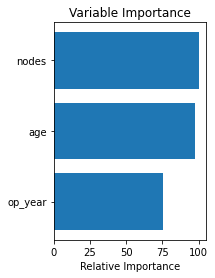

In [17]:
feature_importance = best_results.feature_importances_

# Make importances relative to max importance.
feature_importance = 100.0 * (feature_importance / feature_importance.max())
sorted_idx = np.argsort(feature_importance)
pos = np.arange(sorted_idx.shape[0]) + .5
plt.subplot(1, 2, 2)
plt.barh(pos, feature_importance[sorted_idx], align='center')
plt.yticks(pos, X.columns[sorted_idx])
plt.xlabel('Relative Importance')
plt.title('Variable Importance')
plt.show()